In [1]:
import time
from cs336_scaling.common import (
    get_chinchilla_power_law_n_for_c,
    get_chinchilla_n_for_c,
    pick_candidates_around_n,
    get_shape_given_n,
    print_predicted_shapes,
    get_chinchilla_lr_for_n,
    get_shape_for_n_custom,
    power_law,
)

from cs336_scaling.constants import VOCAB_SIZE, BATCH_SIZE, FLOPS_BUDGET
from cs336_scaling.training_api import get_loss, sync_api_state, get_total_flops_used
from cs336_scaling.analyze import (
    best_run_where,
    fit_quadratic,
    find_optimal_params,
    plot_runs,
    get_all_runs,
    plot_loss_vs_lr_at_c_and_n,
    group_by,
    plot_tokens_per_param_vs_loss,
    best_lr_per_n,
)

from scipy.optimize import curve_fit

import numpy as np

In [4]:
def print_flops_stats(total_flops_used: float | None = None):
    if total_flops_used is None:
        total_flops_used = get_total_flops_used()

    print(f"Total FLOPs Used: {total_flops_used:.2e}")
    print(f"Total FLOPs Used (%): {total_flops_used * 100 / FLOPS_BUDGET:.3f}")
    print("-" * 100)


def print_stats_at_c(
    c: float,
    all_runs: list[dict] | None = None,
    best_n: int | None = None,
    sync_api: bool = False,
    best_lr_per_n: bool = True,
):
    if all_runs is None and sync_api is False:
        raise ValueError("Must provide either all_runs or sync_api")

    if sync_api:
        all_runs, total_flops_used = sync_api_state()

    runs_at_c = [run for run in all_runs if run["train_flops"] == c]

    if len(runs_at_c) == 0:
        print(f"No runs found for C = {c:.0e}")
        return

    runs_to_fit = runs_at_c

    if best_lr_per_n:
        group_by_n = group_by(runs_at_c, "est_n_non_embedding")
        for n in group_by_n:
            group_by_n[n] = sorted(group_by_n[n], key=lambda x: x["loss"])[0]

        runs_to_fit = list(group_by_n.values())

    if best_n is not None:
        runs_to_fit = sorted(runs_at_c, key=lambda x: x["loss"])[:best_n]

    fit_fn = fit_quadratic(runs_to_fit)
    coeffs = fit_fn.coeffs
    best_run = min(runs_at_c, key=lambda x: x["loss"])
    best_run_n = best_run["est_n_non_embedding"]
    best_run_n_total = best_run["est_n_total"]
    chinchilla_lr = get_chinchilla_lr_for_n(best_run_n_total)
    pred_opt_n = find_optimal_params(fit_fn)
    pred_opt_loss = fit_fn(np.log(pred_opt_n))

    print(f"Best for C = {c:.0e}:")

    print(f"- Non-embedding params: {best_run_n:.2e} ({best_run_n} params)")
    print(f"- LR: {best_run['learning_rate']:.3e} (chinchilla: {chinchilla_lr:.3e})")
    print(f"- Loss: {best_run['loss']:.5f}")
    print(f"- Total params: {best_run_n_total:.2e} ({best_run_n_total} params)")
    print(f"- Embedding ratio: {best_run['est_embed_ratio']:.2f}")
    print(
        f"- Tokens: {best_run['est_tokens']:.2e} ({int(best_run['est_tokens'])} tokens)"
    )
    print(f"- Tokens per param (D/N): {best_run['est_tokens_per_param']:.3f}")
    print(f"- Aspect ratio: {best_run['d_model'] / best_run['num_layers']:.2f}")
    print(best_run)
    print("-" * 100)

    print(f"Quadratic fit for all runs at {c:.0e} FLOPs:")
    print(f"{coeffs[0]:.4f}x^2 + {coeffs[1]:.4f}x + {coeffs[2]:.4f}")

    print(f"Pred. optimal params: {pred_opt_n:.2e}")
    print(f"Pred. loss at optimal params: {pred_opt_loss:.5f}")

    print("-" * 100)

In [5]:
def sweep_n_at_c(c: float, n_guess: int, factor: float = 5, n_candidates: int = 5, dry_run: bool = False):
    candidates = pick_candidates_around_n(
        n_guess, factor=factor, n_candidates=n_candidates, round_to_int=True
    )
    print_predicted_shapes(ns=candidates, c=c)

    for n in candidates:
        d, L, h, n_star = get_shape_given_n(n)
        lr = get_chinchilla_lr_for_n(n_star)
        bs = BATCH_SIZE

        # res = {"loss": 0.0, "total_flops_used": 0}

        if dry_run:
            print(f"Would run with N={n:.2e}, lr={lr:.3e} at C={c:.0e}")
        else:
            get_loss(
                d_model=d,
                num_layers=L,
                num_heads=h,
                batch_size=bs,
                learning_rate=lr,
            train_flops=c,
        )

    print_stats_at_c(c, sync_api=True)
    print_flops_stats()
    plot_runs()


def sweep_lr_at_cn(
    c: int, n: int, lr_guess: float, factor: float = 3, n_candidates: int = 5, dry_run: bool = False
):
    lr_candidates = pick_candidates_around_n(
        lr_guess, factor=factor, n_candidates=n_candidates, round_to_int=False
    )
    lr_candidates = [c for c in lr_candidates if c >= 1e-4 and c <= 1e-3]

    for lr in lr_candidates:
        d, L, h, n_star = get_shape_given_n(n)
        bs = BATCH_SIZE

        if dry_run:
            print(f"Would run with lr={lr:.3e}, N={n:.2e} at C={c:.0e}")
        else:
            get_loss(
                d_model=d,
                num_layers=L,
                num_heads=h,
                batch_size=bs,
                learning_rate=lr,
            train_flops=c,
        )

    print_stats_at_c(c, sync_api=True)
    print_flops_stats()
    plot_runs()

In [11]:
# INITIAL RUNS CENTERED AROUND CHINCHILlA GUESS (20 tok/param)

best_run_at_3e16 = best_run_where("train_flops", 3e16)


def get_lr(n_total):
    return (
        best_run_at_3e16["learning_rate"]
        * (n_total / best_run_at_3e16["est_n_total"]) ** -0.15
    )


C_3 = 1e17
min_aspect_ratio = 64
max_aspect_ratio = 128

# Get total param count if we want to hit 20 tokens/param
N_3_total_guess = get_chinchilla_n_for_c(C_3, tokens_per_param=10)

# Get a shape that approximately realizes N_1_total_guess
d, L, h, n_realized_total, err, err_pct = get_shape_for_n_custom(
    N_3_total_guess,
    min_aspect_ratio=min_aspect_ratio,
    max_aspect_ratio=max_aspect_ratio,
    n_is_total=True,
)
print(f"N_3_total_guess: {N_3_total_guess:.2e} (error: {err:.2e} = {err_pct:.2f}%)")

# Estimate the non-embedding parameter count in the realised shape
N_3_guess = 12 * L * d**2
print(f"N_3_guess: {N_3_guess:.2e} ({N_3_guess})")

# Get a list of candidate N values to try around the *non-embedding* parameter count
candidates = pick_candidates_around_n(
    N_3_guess, factor=5, n_candidates=15, round_to_int=True
)

# Compute the ratio (same between all candidates) in case we want to extend the list
# ratio = candidates[-1] / candidates[-2]

# Process candidates one at a time, checking results after each (to determine where to explore next)
candidate = N_3_guess
# candidate = candidates[6] # (~27 tok/param

print(f"CANDIDATE: {candidate:.2e} ({candidate})")

print_predicted_shapes(
    ns=candidates,
    get_shape_fn=lambda n: get_shape_for_n_custom(
        n, min_aspect_ratio=min_aspect_ratio, max_aspect_ratio=max_aspect_ratio
    ),
    get_lr_fn=get_lr,
    c=C_3,
)
# ================================

d, L, h, n_realized, *_ = get_shape_for_n_custom(
    candidate, min_aspect_ratio=min_aspect_ratio, max_aspect_ratio=max_aspect_ratio
)
n_embed = 2 * VOCAB_SIZE * d
n_total = n_realized + n_embed

# lr = 9e-4
lr = get_lr(n_total)
# lr = 3.5e-4
bs = BATCH_SIZE

print(d, L, h, n_realized, n_embed, n_total, lr, bs)

res = {"loss": 0.0, "total_flops_used": 0}

# res = get_loss(
#     d_model=d,
#     num_layers=L,
#     num_heads=h,
#     batch_size=bs,
#     learning_rate=lr,
#     train_flops=C_3,
# )

if "loss" not in res:
    print(res)

all_runs = get_all_runs(sync_api=True)
runs_at_c = [run for run in all_runs if run["train_flops"] == C_3]
best_run = min(runs_at_c, key=lambda x: x["loss"]) if runs_at_c else None

print_stats_at_c(c=C_3, all_runs=runs_at_c, best_n=10)

print_flops_stats()
if len(runs_at_c) > 0:
    plot_runs(runs_at_c, best_n_per_c=10, outfile_suffix=f"_{C_3}")
    plot_loss_vs_lr_at_c_and_n(C_3, best_run["est_n_non_embedding"])

N_3_total_guess: 4.08e+07 (error: 1.11e+05 = 0.27%)
N_3_guess: 1.20e+07 (12042240)
CANDIDATE: 1.20e+07 (12042240)
Computed shapes:
  idx	     c	       n	  n_star	     err	err_pct	   tok/n	   d	  L	  d/L	  h	  pred_lr	embed_ratio	   tokens	tok/n_star
    0	 1e+17	2.41e+06	2.36e+06	4.92e+04	  2.04%	   47.44	 256	  3	85.33	  2	 5.33e-04	     0.87	 8.89e+08	  376.89
    1	 1e+17	3.03e+06	2.99e+06	4.50e+04	  1.49%	   36.33	 288	  3	96.00	  3	 5.22e-04	     0.86	 7.78e+08	  260.60
    2	 1e+17	3.81e+06	3.69e+06	1.28e+05	  3.36%	   28.54	 320	  3	106.67	  5	 5.13e-04	     0.85	 6.90e+08	  187.08
    3	 1e+17	4.80e+06	4.92e+06	1.15e+05	  2.39%	   25.84	 320	  4	80.00	  5	 5.09e-04	     0.81	 6.56e+08	  133.52
    4	 1e+17	6.04e+06	5.95e+06	9.42e+04	  1.56%	   20.55	 352	  4	88.00	 11	 5.01e-04	     0.79	 5.85e+08	   98.41
    5	 1e+17	7.60e+06	7.43e+06	1.69e+05	  2.22%	   18.57	 352	  5	70.40	 11	 4.97e-04	     0.75	 5.56e+08	   74.82
    6	 1e+17	9.57e+06	9.63e+06	6.51e+04	  0.68%	   11.36	 4

N_1_opt_so_far: 1.54e+06 (1536000)
CANDIDATE: 9.68e+05 (967619)
Computed shapes:
  idx	     c	       n	  n_star	     err	err_pct	   tok/n	   d	  L	  d/L	  h	  pred_lr	embed_ratio	   tokens	tok/n_star
    0	 1e+16	7.68e+05	7.86e+05	1.84e+04	  2.40%	   20.68	 128	  4	32.00	  2	 2.46e-04	     0.91	 1.86e+08	  236.04
    1	 1e+16	9.68e+05	9.95e+05	2.77e+04	  2.86%	   15.98	 144	  4	36.00	  3	 2.42e-04	     0.90	 1.63e+08	  163.98
    2	 1e+16	1.22e+06	1.23e+06	9.68e+03	  0.79%	   12.67	 160	  4	40.00	  5	 2.40e-04	     0.89	 1.45e+08	  118.26
    3	 1e+16	1.54e+06	1.54e+06	0.00e+00	  0.00%	   12.02	 160	  5	32.00	  5	 2.39e-04	     0.87	 1.42e+08	   92.14
    4	 1e+16	1.94e+06	1.77e+06	1.66e+05	  8.57%	    8.43	 192	  4	48.00	  2	 2.35e-04	     0.87	 1.19e+08	   67.00
    5	 1e+16	2.44e+06	2.41e+06	2.98e+04	  1.22%	    5.94	 224	  4	56.00	  7	 2.31e-04	     0.86	 9.95e+07	   41.33
    6	 1e+16	3.07e+06	3.01e+06	6.14e+04	  2.00%	    5.54	 224	  5	44.80	  7	 2.30e-04	     0.83	 9.61e+07	   3

/Users/brandon/Documents/College/q6-spring-25/cs-336/cs336-a3/cs336_scaling/analyze.py:46: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(log_params, losses, 2)


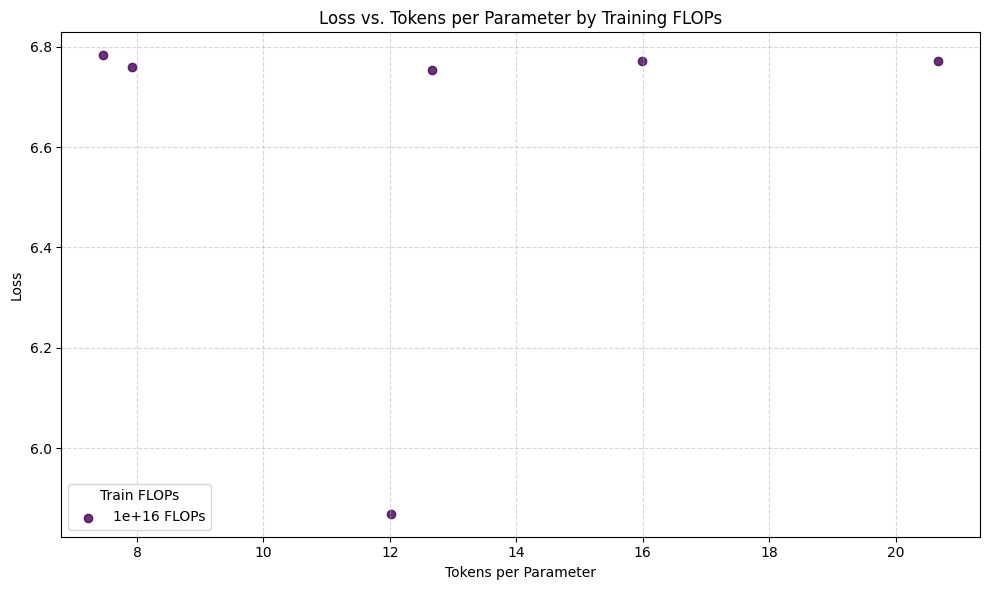

In [5]:
# REFINEMENT RUNS CENTERED AROUND N_1_OPT_SO_FAR
# From best run at C_1 (which was better than quadratic pred. optimal)

N_1_opt_so_far = best_run_where("train_flops", C_3)["est_n_non_embedding"]
print(f"N_1_opt_so_far: {N_1_opt_so_far:.2e} ({N_1_opt_so_far})")

# Get a list of candidate N values to try around the *non-embedding* parameter count
candidates = pick_candidates_around_n(
    N_1_opt_so_far, factor=2, n_candidates=7, round_to_int=True
)

candidate = N_1_opt_so_far
candidate = candidates[1]
print(f"CANDIDATE: {candidate:.2e} ({candidate})")

print_predicted_shapes(
    ns=candidates,
    get_shape_fn=lambda n: get_shape_for_n_custom(
        n, min_aspect_ratio=min_aspect_ratio, max_aspect_ratio=max_aspect_ratio
    ),
    c=C_3,
)

d, L, h, n_realized, *_ = get_shape_for_n_custom(
    candidate, min_aspect_ratio=min_aspect_ratio, max_aspect_ratio=max_aspect_ratio
)
n_embed = 2 * VOCAB_SIZE * d
n_total = n_realized + n_embed
lr = get_chinchilla_lr_for_n(n_total)
bs = BATCH_SIZE

print(d, L, h, n_realized, n_embed, n_total, lr, bs)

res = {"loss": 0.0, "total_flops_used": 0}

# res = get_loss(
#     d_model=d,
#     num_layers=L,
#     num_heads=h,
#     batch_size=bs,
#     learning_rate=lr,
#     train_flops=C_1,
# )

if not res.get("loss"):
    print(res)

all_runs = get_all_runs(sync_api=True)
runs_at_c = [run for run in all_runs if run["train_flops"] == C_3]

print_stats_at_c(c=C_3, all_runs=runs_at_c, best_n=6)

print_flops_stats()
if len(runs_at_c) > 0:
    plot_runs(runs_at_c, best_n_per_c=6, outfile_suffix=f"_{C_3}")

N_1_opt_so_far: 1.54e+06 (1536000)
LR candidates:
0: 0.00012364235463365147
1: 0.00015402510661405357
2: 0.0001918738407867053
3: 0.0002390231799708606
4: 0.000297758570574989
5: 0.0003709270639009542
6: 0.0004620753198421609
7: 0.0005756215223601161
8: 0.0007170695399125815
----------------------------------------------------------------------------------------------------
160 5 5 1536000 10240000 11776000 0.0007170695399125815 128
{'loss': 0.0, 'total_flops_used': 0}


/Users/brandon/Documents/College/q6-spring-25/cs-336/cs336-a3/cs336_scaling/analyze.py:46: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(log_params, losses, 2)


Best for C = 1e+16:
- Non-embedding params: 1.54e+06 (1536000 params)
- LR: 5.756e-04 (chinchilla: 2.390e-04)
- Loss: 5.86882
- Total params: 1.18e+07 (11776000 params)
- Embedding ratio: 0.87
- Tokens: 1.42e+08 (141530797 tokens)
- Tokens per param (D/N): 12.019
- Aspect ratio: 32.00
{'d_model': 160, 'num_layers': 5, 'num_heads': 5, 'batch_size': 128, 'learning_rate': 0.0005756215, 'train_flops': 1e+16, 'loss': 5.86882209777832, 'est_n_total': 11776000, 'est_n_non_embedding': 1536000, 'est_n_embed': 10240000, 'est_embed_ratio': 0.8695652173913043, 'est_tokens': 141530797.10144928, 'est_tokens_per_param': 12.018579916902961, 'sync_time': 1746562212.633309}
----------------------------------------------------------------------------------------------------
Quadratic fit for all runs at 1e+16 FLOPs:
-0.0893x^2 + 0.1430x + 22.3076
Pred. optimal params: nan
Pred. loss at optimal params: nan
----------------------------------------------------------------------------------------------------

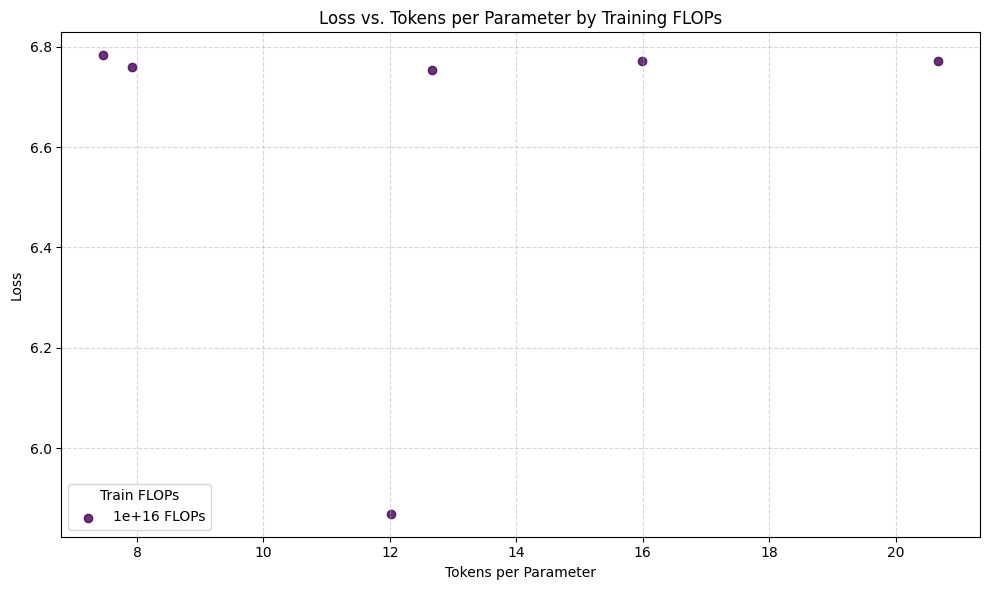

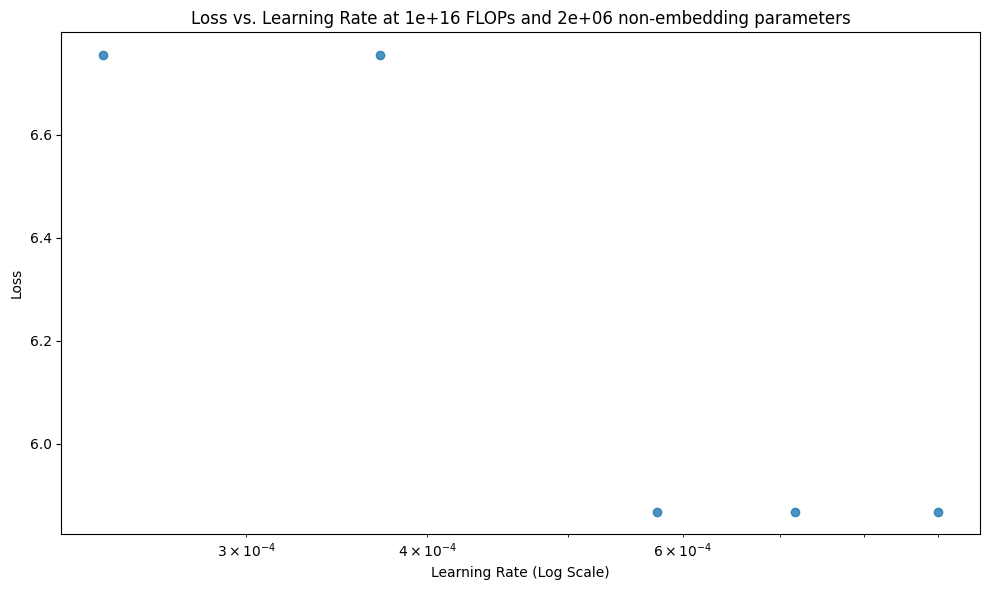

In [6]:
# LEARNING RATE EXPLORATION USING N_1_OPT_SO_FAR
# From new best run at C_1 (better than quadratic pred. optimal)

C_3 = 1e16
min_aspect_ratio = 32
max_aspect_ratio = 64

N_1_opt_so_far = best_run_where("train_flops", C_3)["est_n_non_embedding"]
print(f"N_1_opt_so_far: {N_1_opt_so_far:.2e} ({N_1_opt_so_far})")

d, L, h, n_realized, *_ = get_shape_for_n_custom(
    N_1_opt_so_far, min_aspect_ratio=min_aspect_ratio, max_aspect_ratio=max_aspect_ratio
)
n_embed = 2 * VOCAB_SIZE * d
n_total = n_realized + n_embed
bs = BATCH_SIZE

lr_guess = get_chinchilla_lr_for_n(n_total)

lr_candidates = pick_candidates_around_n(
    lr_guess, factor=3, n_candidates=11, round_to_int=False
)
lr_candidates = [c for c in lr_candidates if c >= 1e-4 and c <= 1e-3]

print("LR candidates:")
for i, lr in enumerate(lr_candidates):
    print(f"{i}: {lr}")
print("-" * 100)

print(d, L, h, n_realized, n_embed, n_total, lr, bs)

candidate = lr_candidates[3]  # lr_guess, because bottom few are out of range
candidate = lr_candidates[5]
candidate = lr_candidates[7]
candidate = lr_candidates[8]
candidate = 9e-4

res = {"loss": 0.0, "total_flops_used": 0}

# res = get_loss(
#     d_model=d,
#     num_layers=L,
#     num_heads=h,
#     batch_size=bs,
#     learning_rate=candidate,
#     train_flops=C_1,
# )

if not res.get("loss"):
    print(res)

all_runs = get_all_runs(sync_api=True)
runs_at_c = [run for run in all_runs if run["train_flops"] == C_3]

print_stats_at_c(c=C_3, all_runs=runs_at_c, best_n=6)

print_flops_stats()
if len(runs_at_c) > 0:
    plot_runs(runs_at_c, best_n_per_c=6, outfile_suffix=f"_{C_3}")
    plot_loss_vs_lr_at_c_and_n(C_3, N_1_opt_so_far)

N_1_opt_so_far: 9.95e+05 (995328)
CANDIDATE: 4.98e+05 (497664)
Computed shapes:
  idx	     c	       n	  n_star	     err	err_pct	   tok/n	   d	  L	  d/L	  h	  pred_lr	embed_ratio	   tokens	tok/n_star
    0	 1e+16	4.98e+05	4.52e+05	4.61e+04	  9.26%	   28.71	 112	  3	37.33	  7	 6.01e-04	     0.94	 2.19e+08	  484.37
    1	 1e+16	6.27e+05	5.90e+05	3.72e+04	  5.93%	   21.61	 128	  3	42.67	  2	 5.93e-04	     0.93	 1.90e+08	  321.77
    2	 1e+16	7.90e+05	7.86e+05	3.56e+03	  0.45%	   20.68	 128	  4	32.00	  2	 5.91e-04	     0.91	 1.86e+08	  236.04
    3	 1e+16	9.95e+05	9.95e+05	0.00e+00	  0.00%	   15.98	 144	  4	36.00	  3	 5.84e-04	     0.90	 1.63e+08	  163.98
    4	 1e+16	1.25e+06	1.23e+06	2.52e+04	  2.01%	   12.67	 160	  4	40.00	  5	 5.77e-04	     0.89	 1.45e+08	  118.26
    5	 1e+16	1.58e+06	1.54e+06	4.40e+04	  2.78%	   12.02	 160	  5	32.00	  5	 5.76e-04	     0.87	 1.42e+08	   92.14
    6	 1e+16	1.99e+06	1.77e+06	2.21e+05	 11.11%	    8.43	 192	  4	48.00	  2	 5.66e-04	     0.87	 1.19e+08	   67

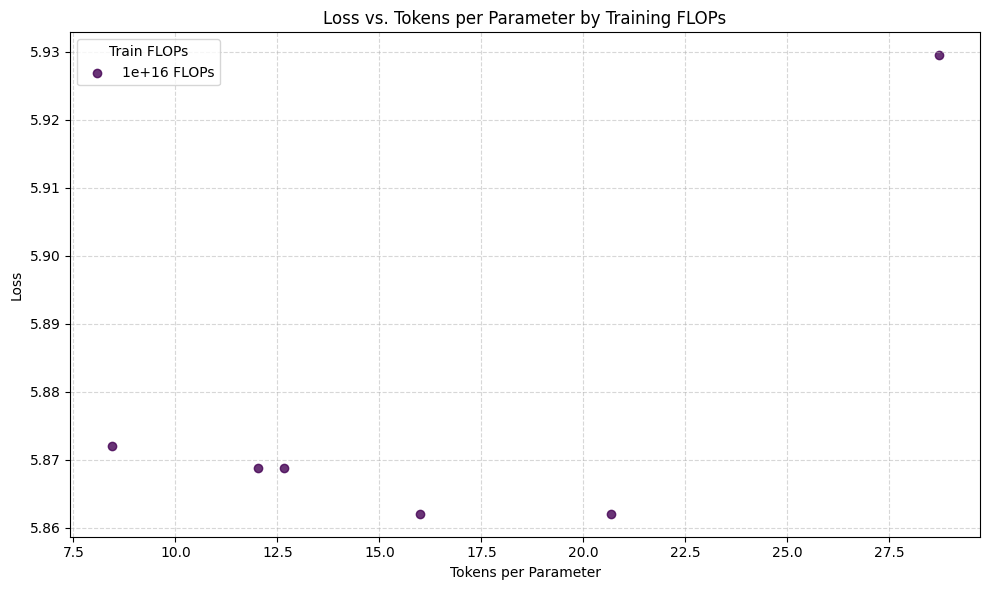

In [35]:
# RE-TESTING MODEL SIZES WITH NEW LR LAW IMPLIED BY BEST LR FROM TESTS

best_run = best_run_where("train_flops", C_3)

def get_lr(n_total):
	return best_run["learning_rate"] * (n_total / best_run["est_n_total"])**-0.1

# def get_lr(n_total):
# 	return 5.75e-4 * (n_total / best_run["est_n_total"])**-0.1

N_1_opt_so_far = best_run_where("train_flops", C_3)["est_n_non_embedding"]
print(f"N_1_opt_so_far: {N_1_opt_so_far:.2e} ({N_1_opt_so_far})")

# Get a list of candidate N values to try around the *non-embedding* parameter count
candidates = pick_candidates_around_n(
    N_1_opt_so_far, factor=2, n_candidates=7, round_to_int=True
)

candidate = N_1_opt_so_far
candidate = candidates[0]
# candidate = candidates[2]
# candidate = candidates[4]
# candidate = candidates[6]
print(f"CANDIDATE: {candidate:.2e} ({candidate})")

print_predicted_shapes(
    ns=candidates,
    get_shape_fn=lambda n: get_shape_for_n_custom(
        n, min_aspect_ratio=min_aspect_ratio, max_aspect_ratio=max_aspect_ratio
    ),
    get_lr_fn=get_lr,
    c=C_3,
)

d, L, h, n_realized, *_ = get_shape_for_n_custom(
    candidate, min_aspect_ratio=min_aspect_ratio, max_aspect_ratio=max_aspect_ratio
)
n_embed = 2 * VOCAB_SIZE * d
n_total = n_realized + n_embed
lr = get_lr(n_total)
bs = BATCH_SIZE

print(d, L, h, n_realized, n_embed, n_total, lr, bs)

res = {"loss": 0.0, "total_flops_used": 0}

# res = get_loss(
#     d_model=d,
#     num_layers=L,
#     num_heads=h,
#     batch_size=bs,
#     learning_rate=lr,
#     train_flops=C_1,
# )

if not res.get("loss"):
    print(res)

all_runs = get_all_runs(sync_api=True)
runs_at_c = [run for run in all_runs if run["train_flops"] == C_3]

print_stats_at_c(c=C_3, all_runs=runs_at_c, best_n=6)

print_flops_stats()
if len(runs_at_c) > 0:
    plot_runs(runs_at_c, best_n_per_c=6, outfile_suffix=f"_{C_3}")



In [31]:
# NEW LR LAW IMPLIED BY BEST LR AT 1e16

best_run = best_run_where("train_flops", C_3)

print(f"Best run LR: {best_run['learning_rate']:.3e}")
print(f"Best run N_total: {best_run['est_n_total']:.2e} ({best_run['est_n_total']:,})")

def get_lr(n_total):
	return best_run["learning_rate"] * (n_total / best_run["est_n_total"])**-0.2

print(get_lr(1.18e7))
print(get_lr(1e8)) # 100M
print(get_lr(4e8)) # 400M
print(get_lr(1e9)) # 1B

Best run LR: 5.839e-04
Best run N_total: 1.02e+07 (10,211,328)
0.0005672423226967941
0.0003699517006802244
0.0002803709607648561
0.00023342374264712567


In [14]:
# NEW TOTAL PARAMS EST. IF MATCHING BEST-SO-FAR TOKENS/PARAM

best_run = best_run_where("train_flops", C_3)

print(f"Tokens/param: {best_run['est_tokens_per_param']:.2f}")

def get_n_total(c):
  return get_chinchilla_n_for_c(c, tokens_per_param=best_run['est_tokens_per_param'])

print(f"Empirical N_total at 1e16: {get_n_total(C_3):.2e} ({get_n_total(C_3):,})")
print(f"N_total at 1e17: {get_n_total(1e17):.2e} ({get_n_total(1e17):,})")
print(f"N_total at 1e18: {get_n_total(1e18):.2e} ({get_n_total(1e18):,})")
print(f"N_total at 1e19: {get_n_total(1e19):.2e} ({get_n_total(1e19):,})")
print(f"N_total at 1e20: {get_n_total(1e20):.2e} ({get_n_total(1e20):,})")


Tokens/param: 12.02
Empirical N_total at 1e16: 1.18e+07 (11,776,000)
N_total at 1e17: 3.72e+07 (37,238,981)
N_total at 1e18: 1.18e+08 (117,760,000)
N_total at 1e19: 3.72e+08 (372,389,817)
N_total at 1e20: 1.18e+09 (1,177,600,000)


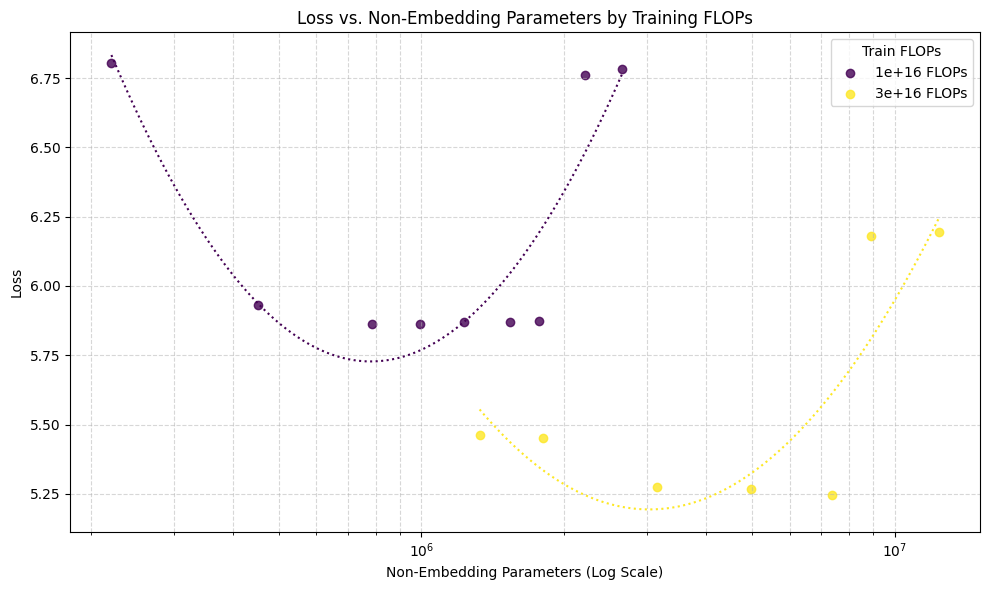

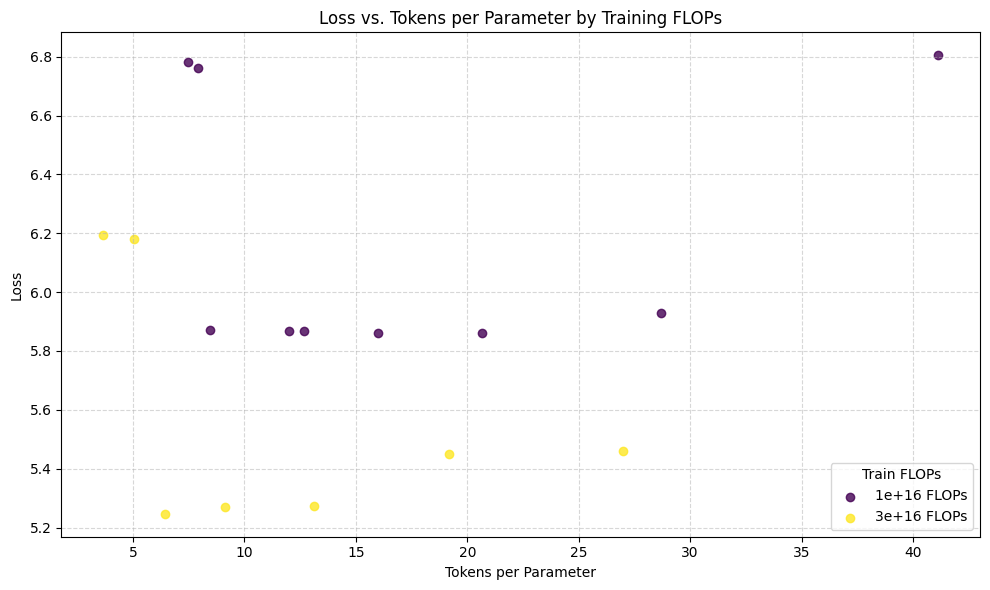

In [ ]:
runs = get_all_runs()
runs = [run for run in runs if run["train_flops"] >= 1e16]
plot_runs(runs, best_n_per_c=10)
plot_tokens_per_param_vs_loss(runs, best_n_per_c=10)

In [4]:
def fit_power_law(c_to_n_opt: dict[float, int]) -> tuple[float, float]:
    """Fits a power law N = a * C^b to the optimal parameter data."""
    budgets = sorted(list(c_to_n_opt.keys()))
    x = np.array(budgets)
    y = np.array([c_to_n_opt[b] for b in budgets])

    # Set initial guess for exponent = 0.5 based on Hoffman et. al
    popt, _ = curve_fit(power_law, x, y)
    return tuple(popt)

In [7]:
all_runs = get_all_runs()
runs_1e16 = best_lr_per_n([run for run in all_runs if run["train_flops"] == 1e16])
runs_3e16 = best_lr_per_n([run for run in all_runs if run["train_flops"] == 3e16])

fit_1e16 = fit_quadratic(runs_1e16)
fit_3e16 = fit_quadratic(runs_3e16)

opt_params_1e16 = int(find_optimal_params(fit_1e16))
opt_params_3e16 = int(find_optimal_params(fit_3e16))

opt_loss_1e16 = fit_1e16(np.log(opt_params_1e16))
opt_loss_3e16 = fit_3e16(np.log(opt_params_3e16))

print(f"Optimal N (non-embedding) at 1e16: {opt_params_1e16:.2e} ({opt_params_1e16:,})")
print(f"Optimal N (non-embedding) at 3e16: {opt_params_3e16:.2e} ({opt_params_3e16:,})")

print(f"Optimal loss at 1e16: {opt_loss_1e16:.5f}")
print(f"Optimal loss at 3e16: {opt_loss_3e16:.5f}")

c_to_n_opt = {
    1e16: opt_params_1e16,
    3e16: opt_params_3e16,
}

a, b = fit_power_law(c_to_n_opt)
print(f"Power law: N = {a:.2e} * C^{b:.2f}")

for c in [1e16, 3e16, 1e17, 1e18, 1e19, 1e20]:
    pred_opt_n = int(power_law(c, a, b))
    print(f"Predicted optimal N at {c:.2e}: {pred_opt_n:.2e} ({pred_opt_n:,})")

Optimal N (non-embedding) at 1e16: 7.82e+05 (781,575)
Optimal N (non-embedding) at 3e16: 3.03e+06 (3,029,877)
Optimal loss at 1e16: 5.72761
Optimal loss at 3e16: 5.19385
Power law: N = 1.44e-14 * C^1.23
Predicted optimal N at 1.00e+16: 7.82e+05 (781,575)
Predicted optimal N at 3.00e+16: 3.03e+06 (3,029,877)
Predicted optimal N at 1.00e+17: 1.34e+07 (13,375,623)
Predicted optimal N at 1.00e+18: 2.29e+08 (228,906,123)
Predicted optimal N at 1.00e+19: 3.92e+09 (3,917,425,873)
Predicted optimal N at 1.00e+20: 6.70e+10 (67,041,568,039)


/var/folders/rf/hpfv3sm53bx8r7lfnyh2mws80000gn/T/ipykernel_83605/1835677398.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(power_law, x, y)
